In [1]:
#Import pandas and matplotlib.pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
#Import cleaned data
data = pd.read_csv('data/clean_data/clean_data.csv')

In [3]:
#View the data

data['ProductCode'] = data['ProductCode'].values.astype('str')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6584 entries, 0 to 6583
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Treatment_Date    6584 non-null   object 
 1   Age               6584 non-null   int64  
 2   Sex               6584 non-null   object 
 3   Narrative         6584 non-null   object 
 4   Diagnosis         6584 non-null   object 
 5   Other_Diagnosis   986 non-null    object 
 6   BodyPart          6584 non-null   object 
 7   Disposition       6584 non-null   object 
 8   ProductCode       6584 non-null   object 
 9   Device_category   6584 non-null   object 
 10  Device_type       6584 non-null   object 
 11  Location          6584 non-null   object 
 12  Stratum           6584 non-null   object 
 13  PSU               6584 non-null   int64  
 14  Weight            6584 non-null   float64
 15  CPSC_Case_Number  6584 non-null   int64  
dtypes: float64(1), int64(3), object(12)
memory

In [4]:
data.head()

,Treatment_Date,Age,Sex,Narrative,Diagnosis,Other_Diagnosis,BodyPart,Disposition,ProductCode,Device_category,Device_type,Location,Stratum,PSU,Weight,CPSC_Case_Number
0,12/31/2017,3,F,3 YOF JUMPING BOUNCE HOUSE W/MOM JUMPED UP LAN...,Fracture,NaN,"Leg, lower",Treated and released,1293,Inflatables,inflatable,Sports/recreation,C,32,4.7570,180125260
1,12/31/2017,10,F,10YOF PLAYING *** AT *** AT A PARTY AT *** LOC...,Dental injury,NaN,Mouth,Treated and released,1293,Not identified or unrelated,not identified,Sports/recreation,C,8,4.7570,180108428
2,12/31/2017,14,M,14YOM- PT WAS PLAYING *** TODAY SWELLING TO RI...,Other,TENDONITIS,Knee,Treated and released,1293,Not identified or unrelated,not identified,Sports/recreation,C,90,4.7570,180120413
3,12/30/2017,2,F,2 YOF JUMPING IN BOUNCE HOUSE LANDED AWKWARDLY...,Fracture,NaN,"Leg, lower",Treated and released,1293,Inflatables,inflatable,Sports/recreation,C,32,4.7570,180125238
4,12/30/2017,17,F,"17YOF DRIVING GO CART, RAN INTO BARRIER, HIT L...","Strain, sprain",NaN,Hand,Treated and released,3259,Go karts,go kart,Sports/recreation,M,54,79.1731,180135290


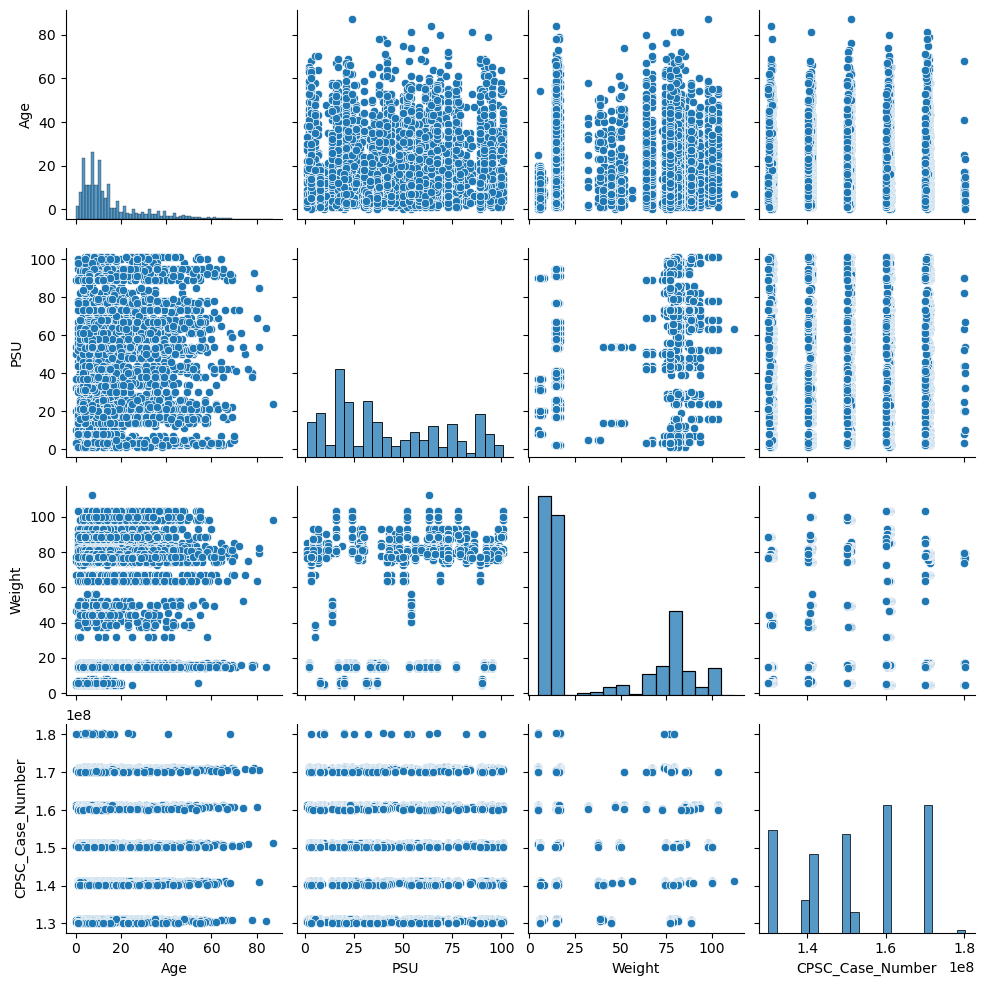

In [5]:
sns.pairplot(data)

In [6]:
#ECDF Function
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / n
    
    return x,y

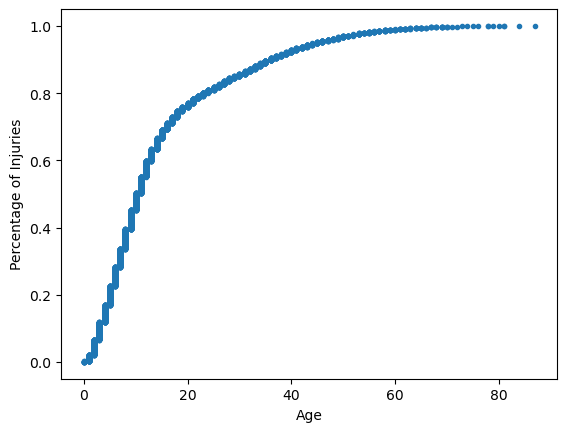

In [7]:
#Majority of injuries (around 80% occur for people 20 and under)
x, y = ecdf(data['Age'])

_ = plt.plot(x, y, marker = '.', linestyle='none')
_ = plt.xlabel('Age')
_ = plt.ylabel('Percentage of Injuries')
plt.show()

<Figure size 640x480 with 0 Axes>

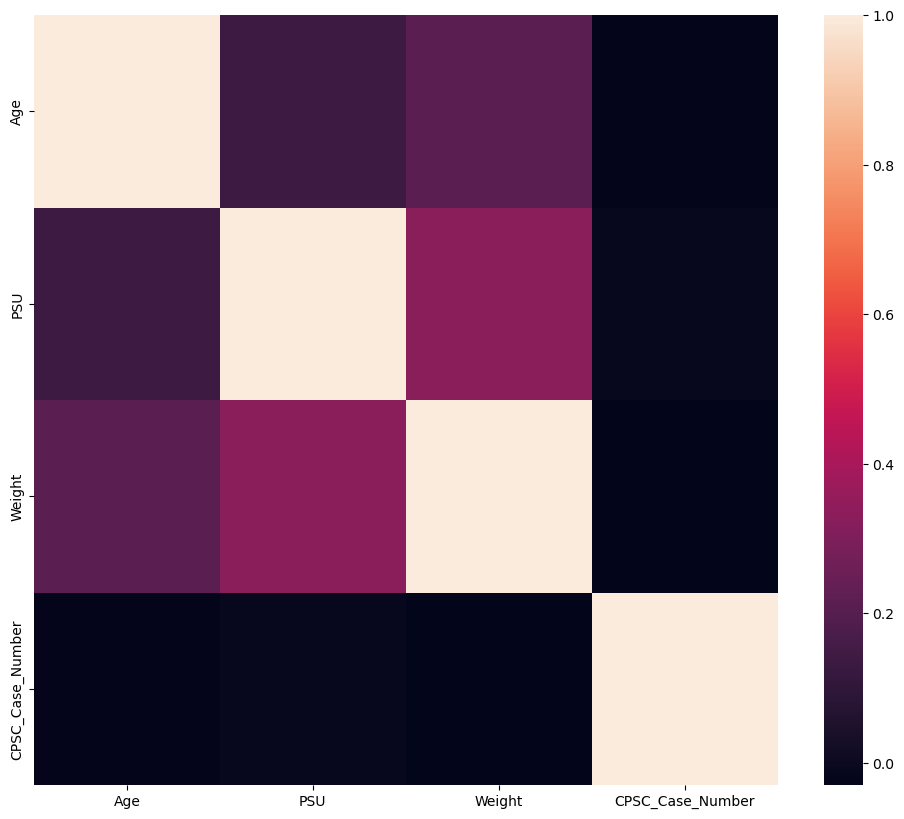

In [8]:
#None of the continuouse variables seem to be correlated to each other. 

plt.clf()
plt.subplots(figsize=(12,10))
sns.heatmap(data.corr())
plt.show()

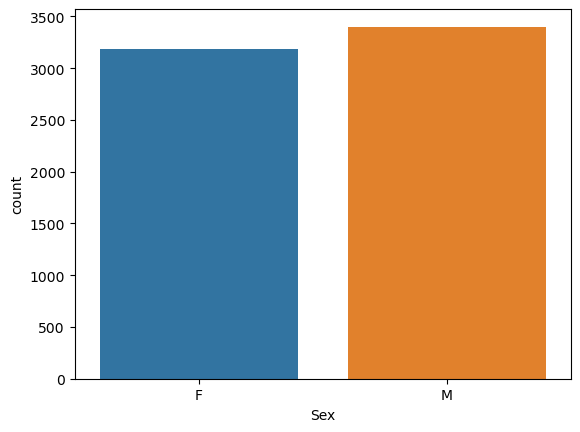

In [9]:
# Sex Count
#Pretty even distribution of males vs females with a slight majority to the males. 

sns.countplot(x='Sex', data= data)
plt.show()

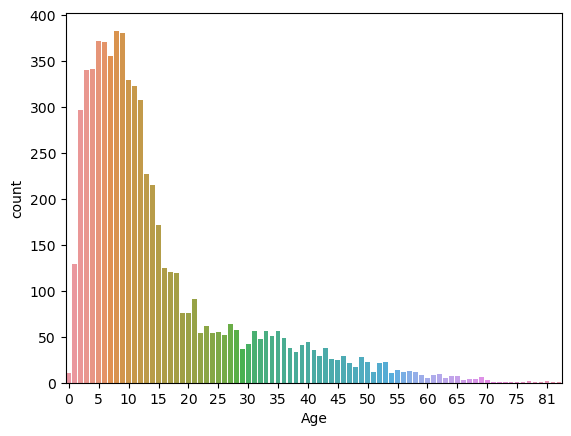

In [10]:
#Age Count
#A majority of the injuries are occuring in people under the age of 20. 

sns.countplot(x='Age', data= data)
plt.xticks(ticks = np.arange(0, 85, step=5))
plt.show()

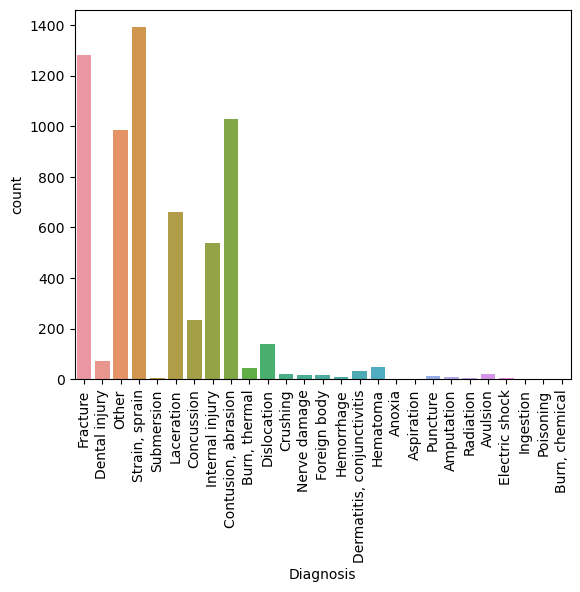

In [11]:
# Diganosis Count
#Strains/Sprains and Fractures are the most common Diagnosis of injuries

sns.countplot(x='Diagnosis', data= data)
plt.xticks(rotation=90)
plt.show()

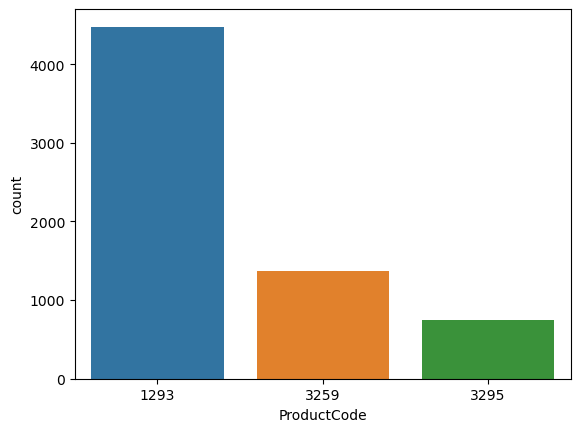

In [12]:
#Product Code Count
#product codes: 1293 (amusement devices), 3295 (water slides, public), and 3259 (go-karts).

sns.countplot(x='ProductCode', data= data)
plt.show()

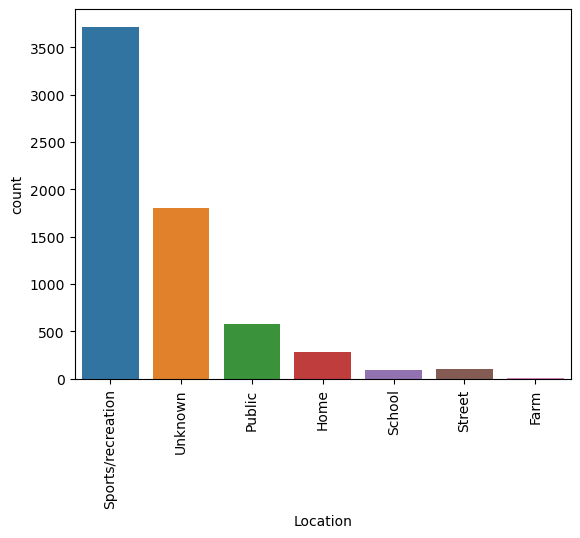

In [13]:
#Location Count. Sports/Recreation is the most common place. 

sns.countplot(x='Location', data= data)
plt.xticks(rotation=90)
plt.show()

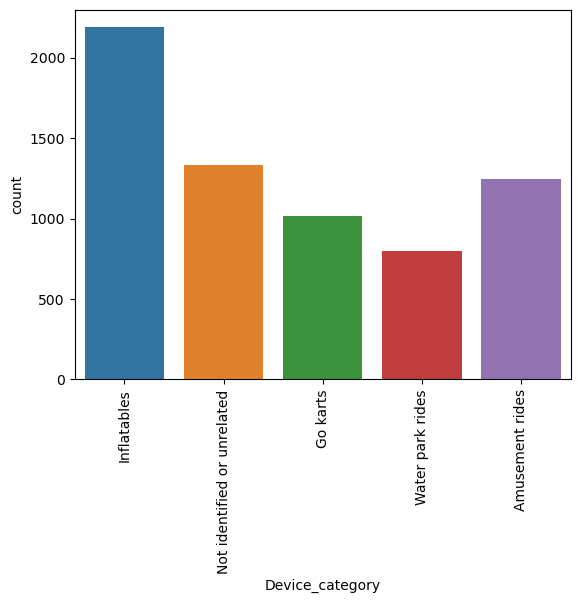

In [14]:
#Device Category Count

sns.countplot(x='Device_category', data= data)
plt.xticks(rotation=90)
plt.show()

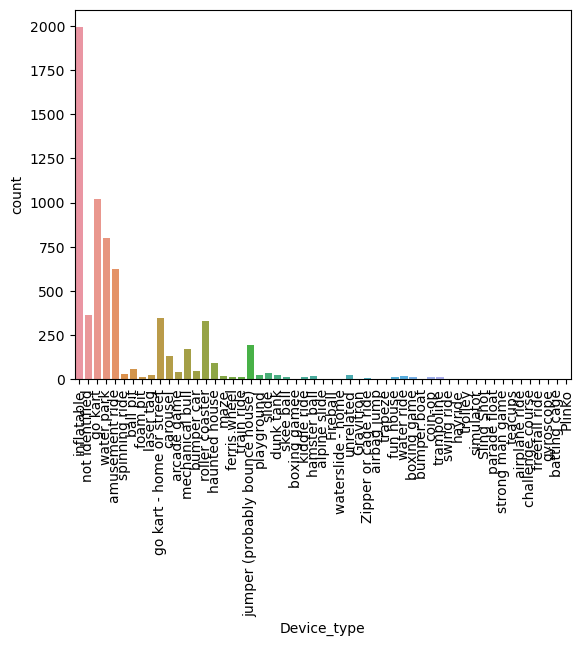

In [15]:
#Inflatables seem to be the most common device that an injury occurs on. Second would be water parks. 

sns.countplot(x='Device_type', data= data)
plt.xticks(rotation=90)
plt.show()

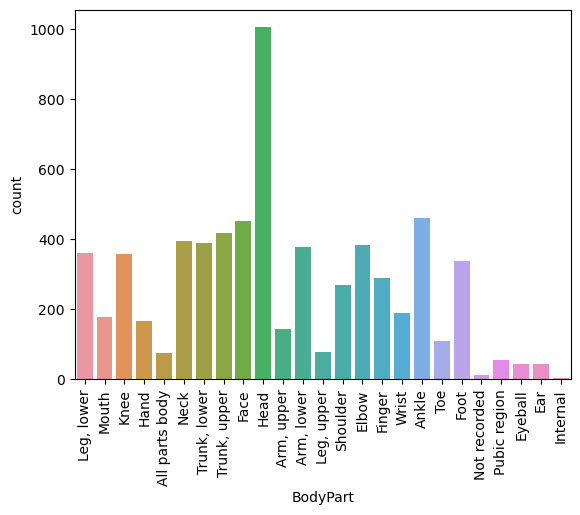

In [16]:
#Head Injuries are the most common.
sns.countplot(x='BodyPart', data= data)
plt.xticks(rotation=90)
plt.show()

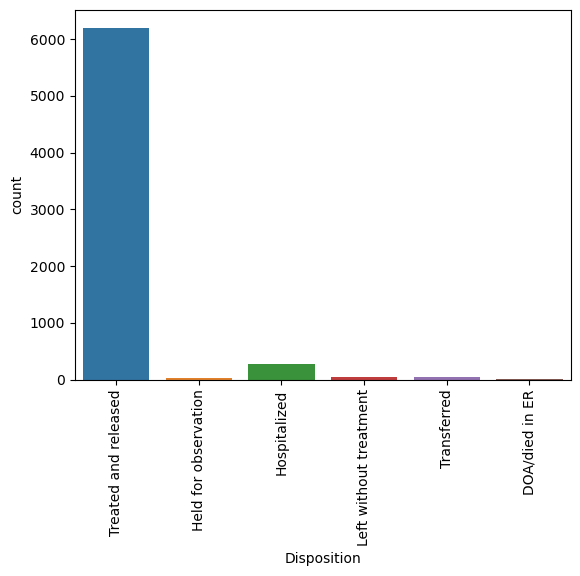

In [17]:
#A majority of the injuries appear to be minor. 
sns.countplot(x='Disposition', data= data)
plt.xticks(rotation=90)
plt.show()

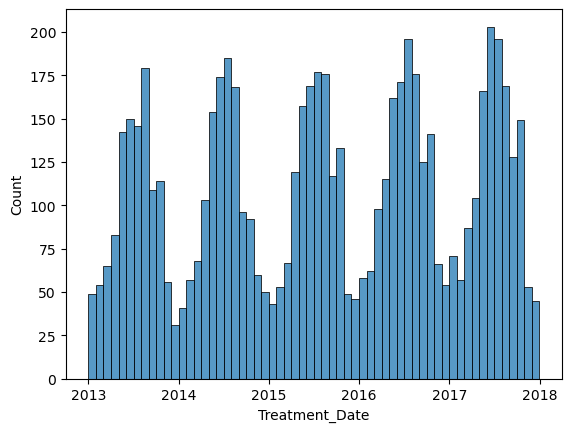

In [27]:
#Convert to Date Time Object
data['Treatment_Date'] = pd.to_datetime(data['Treatment_Date'])

#This histogram shows that the majority of treatments occur in the months of May-Oct (5-10) each year. 
#THis makes sense since it would be the summer months and it is when kids are out of school and doing family vactions. 
sns.histplot(x='Treatment_Date', data= data, bins = 60)
plt.show()